# Unsupervised Segmentation of DAPI dataset

In [61]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
%matplotlib inline
import matplotlib.pyplot as plt

In [63]:
import torch
import genus as gn
import numpy
from genus.util_data import  DataloaderWithLoad, ConditionalRandomCrop, DatasetInMemory
from genus.util import linear_interpolation, append_to_dict, ckpt2file, load_yaml_as_dict, load_obj
from genus.util_vis import show_batch
from genus.model import CompositionalVae, instantiate_optimizer, instantiate_scheduler, process_one_epoch
from functools import partial
import torchvision
from torchvision import transforms

In [64]:
config_file = "./config_VQVAE.yaml"
config = load_yaml_as_dict(config_file)
BATCH_SIZE = config["simulation"]["BATCH_SIZE"]

In [65]:
# We transform them to tensors
transform = transforms.ToTensor()

# Load and transform data
train_data = torchvision.datasets.MNIST('./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.MNIST('./data', train=False, download=True, transform=transform)


train_dataset = DatasetInMemory(x=train_data.data.unsqueeze(-3).float()/(255.0),
                                y=train_data.targets,
                                store_in_cuda=False)
test_dataset = DatasetInMemory(x=test_data.data.unsqueeze(-3).float()/(255.0),
                               y=test_data.targets,
                               store_in_cuda=False)

BATCH_SIZE = 8
test_loader = DataloaderWithLoad(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
train_loader = DataloaderWithLoad(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

### Create the dataloader as usual

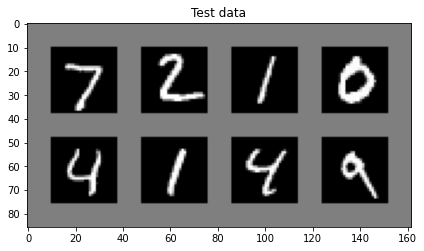

In [66]:
img, _, _ = test_loader.load(index=torch.tensor([0,1,2,3,4,5,6,7]))
show_batch(img, title="Test data",  pad_value=0.5, n_padding=10)

In [67]:
config_file = "./config_VQVAE.yaml"
config = load_yaml_as_dict(config_file)

In [68]:
from typing import NamedTuple, Optional

from genus.encoders_decoders import EncoderConv, DecoderConv
from genus.namedtuple import Output

class MetricMiniBatch(NamedTuple):
    loss: torch.Tensor
    count_prediction: numpy.ndarray
      
    
class ZZ(NamedTuple):
    z: torch.Tensor
    zq: torch.Tensor
    

class VQVAE(torch.nn.Module):
    def __init__(self, ch_img: int, dim_z: int, codebook_size: int) -> None:
        super().__init__()
        self.vq_beta = 0.25
        self.dim_z = dim_z
        self.codebook_size = codebook_size
        self.ch_img = ch_img
        self.encoder = EncoderConv(size=28, ch_in=self.ch_img, dim_z=self.dim_z)
        self.decoder = DecoderConv(size=28, ch_out=self.ch_img, dim_z=self.dim_z)
        self.embedding_KZ = torch.nn.Embedding(self.codebook_size, self.dim_z)
        self.embedding_KZ.weight.data.uniform_(-1.0 / self.codebook_size, 1.0 / self.codebook_size)
    
    def _d2(self, a, b):
        return (a-b).pow(2).sum(dim=-1)
    
    def forward(self, imgs_in, 
                iom_threshold=None, 
                noisy_sampling=None, 
                draw_image=False,
                draw_bg=False,
                draw_boxes=False,
                draw_boxes_ideal=False,
                verbose=False):
        
        z = self.encoder(imgs_in).mu  # B, dim_z        
        d_bk = self._d2(z.unsqueeze(1), self.embedding_KZ.weight)
        j_b = d_bk.min(dim=-1)[1]
        zq = self.embedding_KZ.weight[j_b]
        imgs_out = self.decoder(zq)
        
        if verbose:
            print("imgs_in.shape",imgs_in.shape)
            print("z.shape",z.shape)
            print("j_b.shape", j_b.shape)
            print("zq.shape", zq.shape)
            print("imgs_out.shape",imgs_out.shape)
        
        rec = (imgs_in-imgs_out).pow(2).mean()
        loss = rec + self._d2(z.detach(), zq).mean() + self.vq_beta * self._d2(z, zq.detach()).mean()
        return Output(metrics=MetricMiniBatch(loss=loss.mean(),
                                              count_prediction=-1*numpy.ones(1)),
                      inference=ZZ(z=z, zq=zq), 
                      imgs=imgs_out, 
                      bb_imgs=imgs_in)
        
        
vae = VQVAE(ch_img=1, dim_z=12, codebook_size=30)
a = vae(img, verbose=True)

imgs_in.shape torch.Size([8, 1, 28, 28])
z.shape torch.Size([8, 12])
j_b.shape torch.Size([8])
zq.shape torch.Size([8, 12])
imgs_out.shape torch.Size([8, 1, 28, 28])


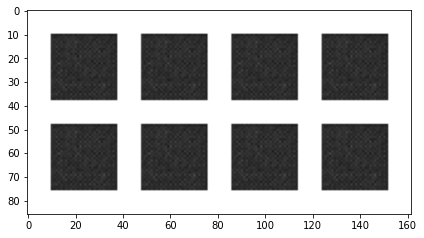

In [71]:
show_batch(a.imgs)

### Instantiate the model, optimizer and scheduler

In [59]:
#vae = CompositionalVae(config)
optimizer = instantiate_optimizer(model=vae, config_optimizer=config["optimizer"])

if config["simulation"]["type"] == "scratch":
    
    epoch_restart = -1
    history_dict = {}
    min_test_loss = 999999

elif config["simulation"]["type"] == "resume":

    if torch.cuda.is_available():
        ckpt = file2ckpt(path="ckpt.pt", device=None)
    else:
        ckpt = file2ckpt(path="ckpt.pt", device='cpu')

    load_from_ckpt(ckpt=ckpt,
                   model=vae,
                   optimizer=optimizer,
                   overwrite_member_var=True)

    epoch_restart = ckpt.get('epoch', -1)
    history_dict = ckpt.get('history_dict', {})
    try:
        min_test_loss = min(history_dict.get("test_loss", 999999))
    except:
        min_test_loss = 999999

elif config["simulation"]["type"] == "pretrained":

    if torch.cuda.is_available():
        ckpt = file2ckpt(path="ckpt.pt", device=None)
    else:
        ckpt = file2ckpt(path="ckpt.pt", device='cpu')

    load_from_ckpt(ckpt=ckpt,
                   model=vae,
                   optimizer=None,
                   overwrite_member_var=False)
       
    epoch_restart = -1
    history_dict = {}
    min_test_loss = 999999
    
else:
    raise Exception("simulation type is NOT recognized")
    
# instantiate the scheduler if necessary    
if config["scheduler"]["is_active"]:
    scheduler = instantiate_scheduler(optimizer=optimizer, config_scheduler=config["scheduler"])
else:
    scheduler = None

### Training loop

In [60]:
TEST_FREQUENCY = config["simulation"]["TEST_FREQUENCY"]
CHECKPOINT_FREQUENCY = config["simulation"]["CHECKPOINT_FREQUENCY"]
NUM_EPOCHS = config["simulation"]["MAX_EPOCHS"]

for epoch in range(1,NUM_EPOCHS+1):
    
    
    vae.train()
    train_metrics = process_one_epoch(model=vae,
                                      dataloader=train_loader,
                                      optimizer=optimizer,
                                      scheduler=scheduler,
                                      iom_threshold=config["architecture"]["nms_threshold_train"],
                                      verbose=(epoch == 0))
    
    with torch.no_grad():
        print("Train " + train_metrics.pretty_print(epoch))
        history_dict = append_to_dict(source=train_metrics,
                                      destination=history_dict,
                                      prefix_exclude="wrong_examples",
                                      prefix_to_add="train_")
        
        if (epoch % TEST_FREQUENCY) == 0:
            vae.eval()
            test_metrics = process_one_epoch(model=vae,
                                             dataloader=test_loader,
                                             optimizer=optimizer,
                                             scheduler=scheduler,
                                             iom_threshold=config["architecture"]["nms_threshold_test"],
                                             verbose=(epoch == 0))
            print("Test  "+test_metrics.pretty_print(epoch))
            history_dict = append_to_dict(source=test_metrics,
                                          destination=history_dict,
                                          prefix_exclude="wrong_examples",
                                          prefix_to_add="test_")
            
        if (epoch % CHECKPOINT_FREQUENCY == 0) and (epoch >= 20):
            ckpt = vae.create_ckpt(optimizer=optimizer,
                                   epoch=epoch,
                                   history_dict=history_dict)
            ckpt2file(ckpt=ckpt, path="last_ckpt_"+str(epoch))

KeyboardInterrupt: 

### Visualize the results (for example MSE)

In [ ]:
plt.imshow()